In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
# from tf.keras.

### mixed precision Rtcores ###
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('Not gpu found !!!')



DATA_DIR = 'eurosatdump'
BATCH_SIZE = 128
AUTO = tf.data.experimental.AUTOTUNE
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

SHUFFLE_BUFFER = int(ds_info.splits['train'].num_examples * 0.8)

ds_train, ds_valid = tfds.load('eurosat/rgb',
                                split=[
tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
tfds.Split.TRAIN.subsplit(tfds.percent[80:])],
data_dir=DATA_DIR,
as_supervised=True)



def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.08)
#     image = tf.image.random_saturation(image, lower=0.95, upper=1.05)
#     image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    return image, label

ds_train = (ds_train
            .map(preprocess, AUTO)
            .cache()
            .shuffle(SHUFFLE_BUFFER)
            .repeat()
            # Augmentations go here .map(augment, AUTO)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTO))

ds_valid = (ds_valid
            .map(preprocess, AUTO)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5
1 Physical GPUs, 1 Logical GPUs


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling...:   0%|          | 0/1 [00:00<?, ? shard/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Reading...: 0 examples [00:00, ? examples/s]

Writing...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Computing statistics...:   0%|          | 0/1 [00:00<?, ? split/s]

0 examples [00:00, ? examples/s]

Dataset eurosat downloaded and prepared to eurosatdump/eurosat/rgb/0.0.1. Subsequent calls will reuse this data.


In [2]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras import regularizers

NUM_CLASSES = ds_info.features['label'].num_classes
acti ='selu'
model = keras.Sequential([
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation=acti),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation=acti),
    layers.Conv2D(32, 3, padding='same', activation=acti),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation=acti),
    layers.Conv2D(64, 3, padding='same', activation=acti),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation=acti),
    layers.Conv2D(128, 3, padding='same', activation=acti),
    layers.MaxPool2D(),
    
    
    layers.Flatten(),
    layers.Dense(128, activation=acti,kernel_regularizer=regularizers.L2(0.001),kernel_initializer='lecun_normal'),
    layers.AlphaDropout(0.5),
    layers.Dense(128, activation=acti,kernel_regularizer=regularizers.L2(0.001),kernel_initializer='lecun_normal'),
    layers.AlphaDropout(0.5),
    layers.Dense(128, activation=acti,kernel_regularizer=regularizers.L2(0.001),kernel_initializer='lecun_normal'),
    layers.AlphaDropout(0.5),
    layers.Dense(128, activation=acti,kernel_regularizer=regularizers.L2(0.001),kernel_initializer='lecun_normal'),
    layers.AlphaDropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax',dtype='float32')
])



In [3]:
lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

EPOCHS = 200
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples * 0.8) // BATCH_SIZE #0.7

early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH)#,callcallbacks=[early_stopping])


model.summary()

Epoch 1/200
168/168 [==============================] - 21s 55ms/step - loss: 2.8533 - sparse_categorical_accuracy: 0.2252 - val_loss: 11.1669 - val_sparse_categorical_accuracy: 0.2922
Epoch 2/200
168/168 [==============================] - 4s 26ms/step - loss: 1.7839 - sparse_categorical_accuracy: 0.4929 - val_loss: 9.8983 - val_sparse_categorical_accuracy: 0.5359
Epoch 3/200
168/168 [==============================] - 4s 26ms/step - loss: 1.3770 - sparse_categorical_accuracy: 0.6392 - val_loss: 6.8742 - val_sparse_categorical_accuracy: 0.6613
Epoch 4/200
168/168 [==============================] - 4s 26ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.7055 - val_loss: 3.3397 - val_sparse_categorical_accuracy: 0.7563
Epoch 5/200
168/168 [==============================] - 4s 26ms/step - loss: 1.0450 - sparse_categorical_accuracy: 0.7391 - val_loss: 4.0042 - val_sparse_categorical_accuracy: 0.7848
Epoch 6/200
168/168 [==============================] - 4s 26ms/step - loss: 0.9498 - spa

Epoch 46/200
168/168 [==============================] - 4s 27ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9764 - val_loss: 4.1439 - val_sparse_categorical_accuracy: 0.9231
Epoch 47/200
168/168 [==============================] - 4s 26ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9784 - val_loss: 2.9239 - val_sparse_categorical_accuracy: 0.9483
Epoch 48/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1899 - sparse_categorical_accuracy: 0.9843 - val_loss: 3.1369 - val_sparse_categorical_accuracy: 0.9456
Epoch 49/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1831 - sparse_categorical_accuracy: 0.9843 - val_loss: 3.9853 - val_sparse_categorical_accuracy: 0.9356
Epoch 50/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1914 - sparse_categorical_accuracy: 0.9827 - val_loss: 3.6161 - val_sparse_categorical_accuracy: 0.9391
Epoch 51/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1977 -

Epoch 91/200
168/168 [==============================] - 5s 27ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9919 - val_loss: 3.8867 - val_sparse_categorical_accuracy: 0.9435
Epoch 92/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9876 - val_loss: 3.4713 - val_sparse_categorical_accuracy: 0.9404
Epoch 93/200
168/168 [==============================] - 4s 27ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9904 - val_loss: 4.1132 - val_sparse_categorical_accuracy: 0.9509
Epoch 94/200
168/168 [==============================] - 5s 27ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.9926 - val_loss: 3.6595 - val_sparse_categorical_accuracy: 0.9470
Epoch 95/200
168/168 [==============================] - 5s 27ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.9848 - val_loss: 3.5855 - val_sparse_categorical_accuracy: 0.9526
Epoch 96/200
168/168 [==============================] - 5s 27ms/step - loss: 0.1400 -

168/168 [==============================] - 4s 25ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9946 - val_loss: 4.1597 - val_sparse_categorical_accuracy: 0.9519
Epoch 180/200
168/168 [==============================] - 4s 26ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9929 - val_loss: 3.9561 - val_sparse_categorical_accuracy: 0.9570
Epoch 181/200
168/168 [==============================] - 5s 27ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9934 - val_loss: 4.8111 - val_sparse_categorical_accuracy: 0.9483
Epoch 182/200
168/168 [==============================] - 5s 27ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9958 - val_loss: 4.6078 - val_sparse_categorical_accuracy: 0.9546
Epoch 183/200
168/168 [==============================] - 4s 26ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9952 - val_loss: 4.9544 - val_sparse_categorical_accuracy: 0.9533
Epoch 184/200
168/168 [==============================] - 4s 26ms/step - loss: 0.0992 - sparse_

<AxesSubplot:>

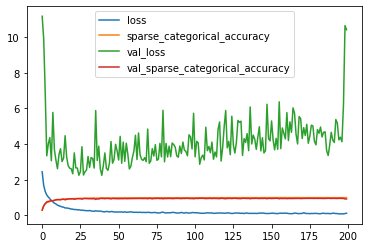

In [4]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

In [ ]:
model.save('Trained_eurosat')